In [15]:
# https://nsidc.org/data/smap_l1_l3_anc_static/versions/1
import numpy as np
import xarray as xr
import netCDF4
import os
import matplotlib.pyplot as plt

# Read static data

In [11]:
data_dir = r"/home/raraki/waves/projects/smap-drydown/data/SMAP_L1_L3_ANC_STATIC"
sand_file = r"sand_M36_004.float32"
landcover_M_file = r"dominantIGBP_M36_B20120101_003.uint8"
landcover_N_file = r"dominantIGBP_N36_B20120101_003.uint8"
lat_M_file = r"EZ2Lat_M36_002.float32"
lat_N_file = r"EZ2Lat_N36_002.float32"
lon_M_file = r"EZ2Lon_M36_002.float32"
lon_N_file = r"EZ2Lon_N36_002.float32"
shape = (406, 964)
width = shape[1]

964

In [13]:
def read_binary_data(filename, dtype, width):
    # Read the file content into a 1D numpy array
    data = np.fromfile(filename, dtype=dtype)
    # Calculate the number of rows
    height = int(data.size // width)
    # Reshape the data to 2D array with known width (964) and calculated height
    return data.reshape((height, width))

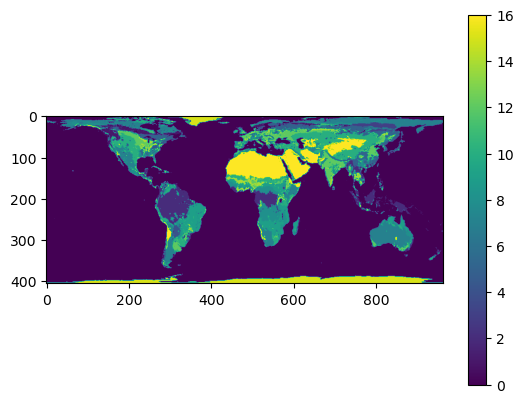

In [24]:
# Read the binary files
sand = read_binary_data(os.path.join(data_dir, sand_file), np.float32, width)
# lat_N = read_binary_data(os.path.join(data_dir, lat_N_file), np.float32, width)
landcover_M = read_binary_data(os.path.join(data_dir, landcover_M_file), np.uint8, width)
# landcover_N = read_binary_data(os.path.join(data_dir, landcover_N_file), np.uint8, width)
# lat_M = read_binary_data(lat_M_file, np.float32, shape)
plt.imshow(landcover_M)
plt.colorbar()

# lon_M = read_binary_data(lon_M_file, np.float32, shape)
# lon_N = read_binary_data(lon_N_file, np.float32, shape)

# Get template EASE grid

In [37]:
SMAPL3_grid_sample = r"/home/waves/projects/smap-drydown/data/SPL3SMP/SMAP_L3_SM_P_20150331_R18290_001.h5"
ncf = netCDF4.Dataset(SMAPL3_grid_sample, diskless=True, persist=False)
nch_am = ncf.groups.get('Soil_Moisture_Retrieval_Data_AM')
nch_pm = ncf.groups.get('Soil_Moisture_Retrieval_Data_PM')

# %%
# Return as regular numpy array rather than masked array
_latitude = ma.getdata(nch_am.variables['latitude'][:].filled(fill_value=np.nan), subok=True)
_longitude = ma.getdata(nch_am.variables['longitude'][:].filled(fill_value=np.nan), subok=True)
_EASE_column_index = ma.getdata(nch_am.variables['EASE_column_index'][:].astype(int).filled(fill_value=-1), subok=True)
_EASE_row_index = ma.getdata(nch_am.variables['EASE_row_index'][:].astype(int).filled(fill_value=-1), subok=True)

# %%
# Coordinates with no data are skipped --- fill them
latitude = np.nanmax(_latitude, axis=1)
EASE_row_index = np.nanmax(_EASE_row_index, axis=1)
longitude = np.nanmax(_longitude, axis=0)
EASE_column_index = np.nanmax(_EASE_column_index, axis=0)

In [57]:
len(EASE_row_index)

406

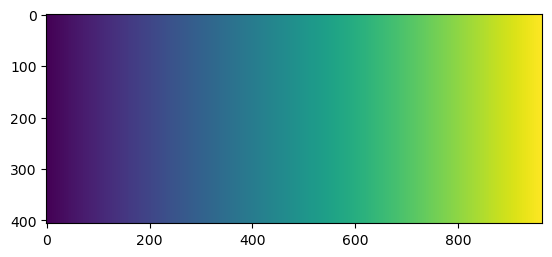

In [61]:
EASE_row_index_expanded = np.tile(EASE_row_index, (len(EASE_column_index), 1)).T 
EASE_column_index_expanded = np.tile(EASE_column_index, (len(EASE_row_index), 1))
plt.imshow(EASE_column_index_expanded)

In [38]:
_ds_SMAPL3 = xr.open_dataset(SMAPL3_grid_sample, engine='rasterio', group='Soil_Moisture_Retrieval_Data_AM', variable=['soil_moisture'])
ds_SMAPL3_coord_template = _ds_SMAPL3.assign_coords({'x':longitude, 'y':latitude}).rio.write_crs("epsg:4326")
ds_SMAPL3_coord_template.sel(band=1).Soil_Moisture_Retrieval_Data_AM_soil_moisture.plot()

# Make sure the EASE grid matches with the cartopy coastline

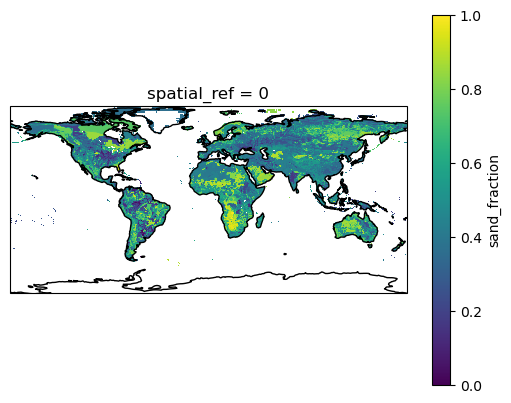

In [47]:
import cartopy.crs as ccrs
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': projection})
# Convert the NumPy array to an xarray DataArray, making sure to align the dimensions and coordinates
sand[(sand < 0) | (sand > 1)] = np.nan
sand_array = xr.DataArray(sand, dims=('y', 'x'), coords={'y': ds_SMAPL3_coord_template['y'], 'x': ds_SMAPL3_coord_template['x']})

# Assign the new DataArray to the Dataset as a new variable
ds_SMAPL3_coord_template['sand_fraction'] = sand_array

# Plot the new data
ds_SMAPL3_coord_template['sand_fraction'].plot(ax=ax, transform=projection, vmin=0, vmax=1)
ax.coastlines()
plt.show()

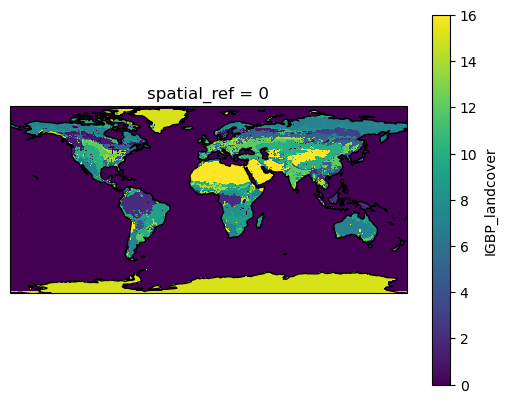

In [50]:
fig, ax = plt.subplots(subplot_kw={'projection': projection})
# Convert the NumPy array to an xarray DataArray, making sure to align the dimensions and coordinates
landcover_array = xr.DataArray(landcover_M, dims=('y', 'x'), coords={'y': ds_SMAPL3_coord_template['y'], 'x': ds_SMAPL3_coord_template['x']})

# Assign the new DataArray to the Dataset as a new variable
ds_SMAPL3_coord_template['IGBP_landcover'] = landcover_array

# Plot the new data
ds_SMAPL3_coord_template['IGBP_landcover'].plot(ax=ax, transform=projection)
ax.coastlines()
plt.show()

In [63]:
EASE_column_index_xarray = xr.DataArray(EASE_column_index_expanded, dims=('y', 'x'), coords={'y': ds_SMAPL3_coord_template['y'], 'x': ds_SMAPL3_coord_template['x']})
ds_SMAPL3_coord_template['EASE_column_index'] = EASE_column_index_xarray

EASE_row_index_xarray = xr.DataArray(EASE_row_index_expanded, dims=('y', 'x'), coords={'y': ds_SMAPL3_coord_template['y'], 'x': ds_SMAPL3_coord_template['x']})
ds_SMAPL3_coord_template['EASE_row_index'] = EASE_row_index_xarray

# Output to dataframe according to EASE grid

In [72]:
new_variable_names = ['sand_fraction', 'IGBP_landcover', 'EASE_column_index', 'EASE_row_index']

# Let's assume ds_SMAPL3_coord_template is your xarray Dataset and 'new_variable_name' is your data variable
# First, stack the DataArray to get a combined multi-index
df = ds_SMAPL3_coord_template[new_variable_names].to_dataframe()
df.index.names = ['latitude', 'longitude']

filename = r"/home/raraki/waves/projects/smap-drydown/data/datarods/anc_info.csv"
df.to_csv(filename)
# # Convert the stacked DataArray to a DataFrame
# df = stacked.to_dataframe()

# # Reset the index to make all index levels into columns
# df = df.reset_index()

# # The indices for 'y' and 'x' are now in the 'pixels' level 0 and level 1 respectively
# df['y_index'] = df['pixels'].get_level_values(0)
# df['x_index'] = df['pixels'].get_level_values(1)

# # Drop the 'pixels' column as it's no longer needed
# df = df.drop(columns=['pixels'])

# # Now df is a pandas DataFrame with columns 'y', 'x', 'new_variable', 'y_index', and 'x_index'


In [74]:
import pandas as pd
data = pd.read_csv(filename)
data.head()

,latitude,longitude,sand_fraction,IGBP_landcover,EASE_column_index,EASE_row_index,spatial_ref
0,83.63197,-179.81328,NaN,0,0,0,0
1,83.63197,-179.43983,NaN,0,1,0,0
2,83.63197,-179.06639,NaN,0,2,0,0
3,83.63197,-178.69295,NaN,0,3,0,0
4,83.63197,-178.31950,NaN,0,4,0,0


# Old code

# Read SMAP associated land cover data

In [35]:
fn = r"G:\Araki\SMSigxSMAP\1_data\SPL3SMP_EASEreference\SMAP_L3_SM_P_20181001_R18290_001.h5"
ncf = netCDF4.Dataset(fn, diskless=True, persist=False)
nch = ncf.groups.get('Soil_Moisture_Retrieval_Data_PM')
nch2 = nch.groups.get('landcover_class_pm')

nch_am = ncf.groups.get('Soil_Moisture_Retrieval_Data_AM')
nch_am_lat = nch.groups.get('latitude')
nch_am_lon = nch.groups.get('longitude')

FileNotFoundError: [Errno 2] No such file or directory: 'G:\\Araki\\SMSigxSMAP\\1_data\\SPL3SMP_EASEreference\\SMAP_L3_SM_P_20181001_R18290_001.h5'

```
 'landcover_class_pm': <class 'netCDF4._netCDF4.Variable'>
 uint8 landcover_class_pm(phony_dim_3, phony_dim_4, phony_dim_5)
     _FillValue: 254
     long_name: An enumerated type that specifies the most common landcover class in the grid cell based on the IGBP landcover map. The array order is longitude (ascending), followed by latitude (descending), and followed by IGBP land cover type descending dominance (only the first three types are listed)
     coordinates: /Soil_Moisture_Retrieval_Data_AM/latitude /Soil_Moisture_Retrieval_Data_AM/longitude
 path = /Soil_Moisture_Retrieval_Data_PM
 unlimited dimensions: 
 current shape = (406, 964, 3)
 filling off,
 ```

c:\Users\raraki8159\.conda\envs\SMAP_v2\Lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
c:\Users\raraki8159\.conda\envs\SMAP_v2\Lib\site-packages\rioxarray\_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


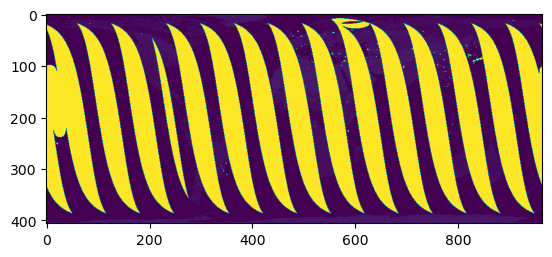

In [139]:
xds_pm = xr.open_dataset(fn, engine='rasterio', group='Soil_Moisture_Retrieval_Data_PM', variable='landcover_class_pm')
xds_pm = xds_pm.rename({'band': 'x', 'x':'band'})
xds_pm = xds_pm.transpose('band', 'y', 'x')
IGBPclass_pm = xds_pm.Soil_Moisture_Retrieval_Data_PM_landcover_class_pm[0].values.transpose()
plt.imshow(IGBPclass_pm)

In [171]:
xds_pm

<xarray.Dataset>
Dimensions:                                             (x: 406, band: 3, y: 964)
Coordinates:
  * x                                                   (x) int32 1 2 ... 406
  * band                                                (band) float64 0.5 .....
  * y                                                   (y) float64 0.5 ... 9...
    spatial_ref                                         int32 ...
Data variables:
    Soil_Moisture_Retrieval_Data_PM_landcover_class_pm  (band, y, x) float32 ...
Attributes: (12/698)
    Metadata_AcquisitionInformation_platformDocument_edition:                ...
    Metadata_AcquisitionInformation_platformDocument_publicationDate:        ...
    Metadata_AcquisitionInformation_platformDocument_title:                  ...
    Metadata_AcquisitionInformation_platform_antennaRotationRate:            ...
    Metadata_AcquisitionInformation_platform_description:                    ...
    Metadata_AcquisitionInformation_platform_identifier:                     ...
    ...                                                                          ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_coordinates: ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_long_name:   ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_units:       ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_valid_max:   ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_valid_min:   ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm__FillValue:  ...

c:\Users\raraki8159\.conda\envs\SMAP_v2\Lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
c:\Users\raraki8159\.conda\envs\SMAP_v2\Lib\site-packages\rioxarray\_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


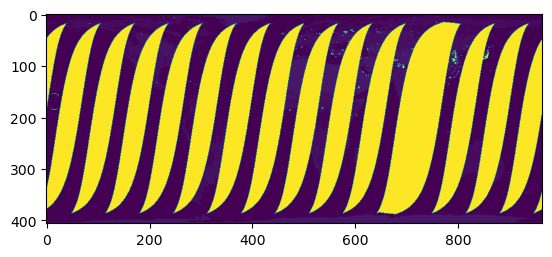

In [140]:
xds_am = xr.open_dataset(fn, engine='rasterio', group='Soil_Moisture_Retrieval_Data_AM', variable='landcover_class')
xds_am = xds_am.rename({'band': 'x', 'x':'band'})
xds_am = xds_am.transpose('band', 'y', 'x')
xds_am
IGBPclass_am = xds_am.Soil_Moisture_Retrieval_Data_AM_landcover_class[0].values.transpose()
plt.imshow(IGBPclass_am)

In [173]:
xds_lat = xr.open_dataset(fn, engine='rasterio', group='Soil_Moisture_Retrieval_Data_AM', variable='latitude')
xds_lat['Soil_Moisture_Retrieval_Data_AM_latitude'] = xds_lat['Soil_Moisture_Retrieval_Data_AM_latitude'].where(xds_lat['Soil_Moisture_Retrieval_Data_AM_latitude'] != -9999, np.nan)
lat = xds_lat['Soil_Moisture_Retrieval_Data_AM_latitude'][0].values

In [176]:
xds_lon = xr.open_dataset(fn, engine='rasterio', group='Soil_Moisture_Retrieval_Data_AM', variable='longitude')
xds_lon['Soil_Moisture_Retrieval_Data_AM_longitude'] = xds_lon['Soil_Moisture_Retrieval_Data_AM_longitude'].where(xds_lon['Soil_Moisture_Retrieval_Data_AM_longitude'] != -9999, np.nan)
lon = xds_lon['Soil_Moisture_Retrieval_Data_AM_longitude'][0].values

In [183]:
lat_complete = np.nanmax(lat, axis=1)
lat_complete

array([ 83.63197   ,  81.48033   ,  79.76896   ,  78.30298   ,
        76.99911   ,  75.81257   ,  74.71601   ,  73.69126   ,
        72.725525  ,  71.80941   ,  70.935745  ,  70.09893   ,
        69.294495  ,  68.51881   ,  67.76884   ,  67.04206   ,
        66.33635   ,  65.64985   ,  64.98099   ,  64.32838   ,
        63.690807  ,  63.0672    ,  62.456604  ,  61.858166  ,
        61.27113   ,  60.6948    ,  60.128555  ,  59.571827  ,
        59.024097  ,  58.484894  ,  57.95379   ,  57.43037   ,
        56.91428   ,  56.40517   ,  55.90273   ,  55.40666   ,
        54.916687  ,  54.43256   ,  53.954033  ,  53.48089   ,
        53.012913  ,  52.549908  ,  52.091694  ,  51.63809   ,
        51.18893   ,  50.74406   ,  50.303333  ,  49.86661   ,
        49.433758  ,  49.00465   ,  48.579163  ,  48.15719   ,
        47.738617  ,  47.32334   ,  46.911266  ,  46.502296  ,
        46.09634   ,  45.693314  ,  45.293133  ,  44.89572   ,
        44.501     ,  44.108894  ,  43.71934   ,  43.33

In [184]:
lon_complete = np.nanmax(lon, axis=0)
lon_complete

array([-179.81328   , -179.43983   , -179.06639   , -178.69295   ,
       -178.3195    , -177.94606   , -177.57262   , -177.19917   ,
       -176.82573   , -176.45229   , -176.07884   , -175.7054    ,
       -175.33195   , -174.95851   , -174.58507   , -174.21162   ,
       -173.83818   , -173.46474   , -173.0913    , -172.71785   ,
       -172.34439   , -171.97095   , -171.5975    , -171.22406   ,
       -170.85062   , -170.47717   , -170.10373   , -169.73029   ,
       -169.35684   , -168.9834    , -168.60995   , -168.23651   ,
       -167.86307   , -167.48962   , -167.11618   , -166.74274   ,
       -166.3693    , -165.99585   , -165.6224    , -165.24896   ,
       -164.87552   , -164.50208   , -164.12863   , -163.75519   ,
       -163.38174   , -163.0083    , -162.63486   , -162.26141   ,
       -161.88797   , -161.51453   , -161.14108   , -160.76764   ,
       -160.3942    , -160.02075   , -159.64731   , -159.27386   ,
       -158.90042   , -158.52698   , -158.15353   , -157.78009

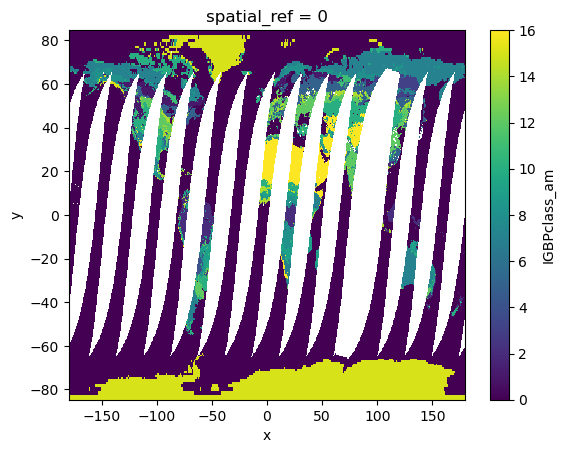

In [189]:
xds_IGBPclass = xr.Dataset(
        {
        "IGBPclass_am": (["y", "x"], IGBPclass_am),
        "IGBPclass_pm": (["y", "x"], IGBPclass_pm)
        },
        coords={
            'y': lat_complete,
            'x': lon_complete,
        }
    )
xds_IGBPclass = xds_IGBPclass.set_coords(["x", "y"])
xds_IGBPclass.rio.write_crs('epsg:4326', inplace=True)
xds_IGBPclass['IGBPclass_am'] = xds_IGBPclass['IGBPclass_am'].where(xds_IGBPclass['IGBPclass_am'] != 254, np.nan)
xds_IGBPclass['IGBPclass_pm'] = xds_IGBPclass['IGBPclass_pm'].where(xds_IGBPclass['IGBPclass_pm'] != 254, np.nan)
xds_IGBPclass.IGBPclass_am.plot()

In [190]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature

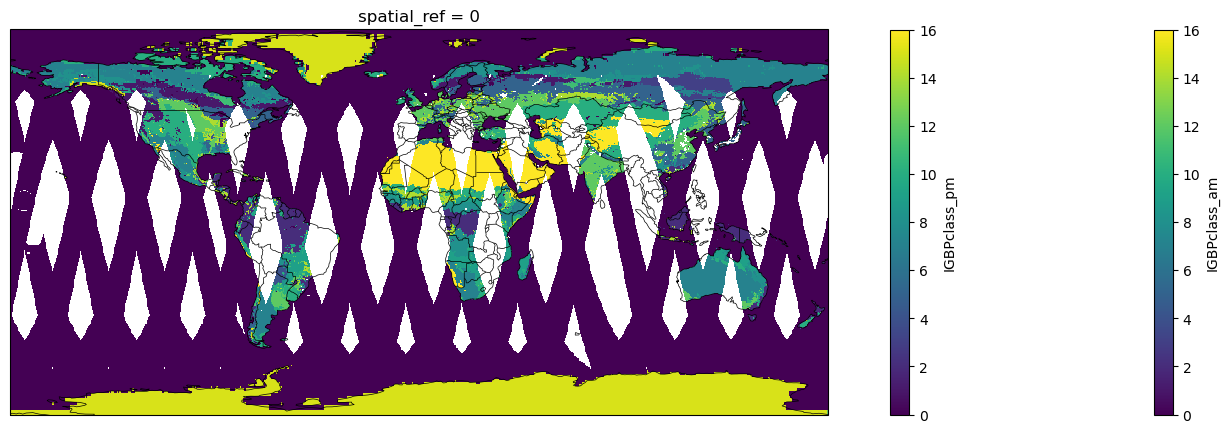

In [193]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20,5))
xds_IGBPclass['IGBPclass_am'].plot(ax=ax, transform=ccrs.PlateCarree())
xds_IGBPclass['IGBPclass_pm'].plot(ax=ax, transform=ccrs.PlateCarree())
# Add continent outlines
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')